In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import copy
from math import *
from functools import reduce
from PIL import Image as Img
from PIL import ImageTk
from PIL import ImageEnhance
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans

In [2]:
# reading in dicom files
import pydicom as dicom

In [3]:
# skimage image processing packages
import skimage
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
from skimage.transform import resize

In [4]:
# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage

In [5]:
# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets

In [6]:
# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
import chart_studio.plotly as py

In [7]:
# set path and load files 
#path = r'C:\Users\adamj\OneDrive\Desktop\DICOM Python\Dicom Files'
#output_path = r'C:\Users\adamj\OneDrive\Desktop\DICOM Python\Numpy Data'
path = '/Users/adamj/OneDrive/Desktop/DICOM Python/Dicom Files/'
output_path = working_path = '/Users/adamj/OneDrive/Desktop/DICOM Python/Numpy Data/'
g = glob(path + '/*.dcm')

In [8]:
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 288 DICOM images.
First 5 filenames:
/Users/adamj/OneDrive/Desktop/DICOM Python/Dicom Files\IM-0001-0001.dcm
/Users/adamj/OneDrive/Desktop/DICOM Python/Dicom Files\IM-0001-0002.dcm
/Users/adamj/OneDrive/Desktop/DICOM Python/Dicom Files\IM-0001-0003.dcm
/Users/adamj/OneDrive/Desktop/DICOM Python/Dicom Files\IM-0001-0004.dcm
/Users/adamj/OneDrive/Desktop/DICOM Python/Dicom Files\IM-0001-0005.dcm


In [9]:
# https://hengloose.medium.com/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed
# https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
# Load all DICOM images from a folder into a list for manipulation
ct_images = os.listdir(path)
slices = [dicom.dcmread(path + '/' + s) for s in ct_images]
slices = [s for s in slices if 'SliceLocation' in s]
slices.sort(key = lambda x: int(x.InstanceNumber))
try:
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
except:
    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
for s in slices:
    s.SliceThickness = slice_thickness
    
pixel_spacing = slices[0].PixelSpacing

In [10]:
# https://hengloose.medium.com/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed
# https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
# Converts all raw voxel values into Houndsfeld Units. 
# HU's are useful because it is standardized across all CT scans regardless 
# of the absolute number of photons the scanner detector captured.

image = np.stack([s.pixel_array for s in slices])
# Convert to int16 (from sometimes int16), 
# should be possible as values should always be low enough (<32k)
image = image.astype(np.int16)
# Set outside-of-scan pixels to 0
# The intercept is usually -1024, so air is approximately 0
image[image == -2000] = 0
    
# Convert to Hounsfeld units (HU)
intercept = slices[0].RescaleIntercept
slope = slices[0].RescaleSlope
    
if slope != 1:
    image = slope * image.astype(np.float64)
    image = image.astype(np.int16)
        
image += np.int16(intercept)
   
patient_pixels = np.array(image, dtype=np.int16)

In [11]:
id = 0
np.save(output_path + "fullimages_%d.npy" % (id), patient_pixels)

In [12]:
def hide_axes(): # gets rid of x and y axes on plots if desired
    ax = plt.gca()
    plt.axis('off')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)

In [13]:
height, width, depth = patient_pixels.shape
print(f'The image object has the following dimensions:\nheight={height}\nwidth={width}\ndepth={depth}.')

The image object has the following dimensions:
height=288
width=512
depth=512.


In [33]:
# slide through dicom images using a slide bar 
#plt.figure(1)
def dicom_animation(x):
    plt.figure(figsize=(4,4))
    plt.imshow(patient_pixels[x], cmap='bone')
    plt.title("Interactive display of MRI Scans")
    hide_axes()
    return x
interact(dicom_animation, x = widgets.IntSlider(value=0, min = 0, max = len(slices)-1), step = 1)

interactive(children=(IntSlider(value=0, description='x', max=287), Output()), _dom_classes=('widget-interact'…

<function __main__.dicom_animation(x)>

In [36]:
# https://www.youtube.com/watch?v=TWdN9TTQis4
axial_aspect_ratio = pixel_spacing[1]/pixel_spacing[0]
sagital_aspect_ratio = pixel_spacing[1]/slice_thickness
coronal_aspect_ratio = slice_thickness/pixel_spacing[0]

img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
volume3D = np.zeros(img_shape)

for i,s in enumerate(slices):
    array2D = s.pixel_array
    volume3D[:,:,i] = array2D

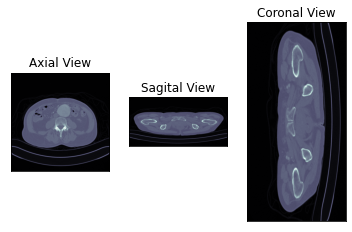

In [39]:
# plots of the image in the axial, sagital, and coronal planes
axial_plot = plt.subplot(1,3,1)
plt.title("Axial View")
hide_axes()
plt.imshow(volume3D[:,:,img_shape[2]//2], cmap = 'bone')
axial_plot.set_aspect(axial_aspect_ratio)

sagital_plot = plt.subplot(1,3,2)
plt.title("Sagital View")
hide_axes()
plt.imshow(volume3D[:,:,img_shape[1]//2], cmap = 'bone')
sagital_plot.set_aspect(sagital_aspect_ratio)

coronal_plot = plt.subplot(1,3,3)
plt.title("Coronal View")
hide_axes()
plt.imshow(volume3D[:,:,img_shape[0]//2].T, cmap = 'bone')
coronal_plot.set_aspect(coronal_aspect_ratio)

In [15]:
# want to use a slider to view all images in the 3 planes
# note: this currently doesn't work. Will try and solve this in the future

#axial = volume3D[:,:,img_shape[2]//2]
#sagital = volume3D[:,:,img_shape[1]//2]
#coronal = volume3D[:,:,img_shape[0]//2].T
#plt.figure(1)

#def dicom_animation(x):
 #   axial_plot = plt.subplot(1,3,1)
  #  plt.title("Axial View")
   # plt.imshow(axial[x])
    #axial_plot.set_aspect(axial_aspect_ratio)

#    sagital_plot = plt.subplot(1,3,2)
 #   plt.title("Sagital View")
  #  plt.imshow(sagital[x])
   # sagital_plot.set_aspect(sagital_aspect_ratio)

#    coronal_plot = plt.subplot(1,3,3)
 #   plt.title("Coronal View")
  #  plt.imshow(coronal[x])
   # coronal_plot.set_aspect(coronal_aspect_ratio)
    #return x
#interact(dicom_animation, x=(0, len(slices)-1))

In [16]:
# https://www.youtube.com/watch?v=TWdN9TTQis4
# Convert all dicom files into JPEG images
def convert(directory):
    im = dicom.dcmread(path + '/' + directory)
    im = im.pixel_array.astype(float)
    rescaled_image = (np.maximum(im,0)/im.max()) * 255
    final_image = np.uint8(rescaled_image)
    final_image = Img.fromarray(final_image)
    return final_image

In [17]:
path = r'C:\Users\adamj\OneDrive\Desktop\DICOM Python\Dicom Files'
ct_images = os.listdir(path)
arr_filename = [x for x in ct_images if x.endswith(".dcm")]

In [18]:
for name in arr_filename:
    image = convert(name)
    image.save(r'C:\Users\adamj\OneDrive\Desktop\DICOM Python\Dicom Images\\' + name + '.jpg')

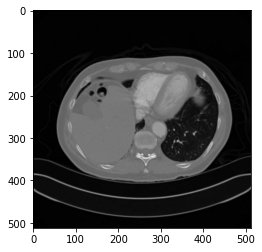

In [21]:
image = Img.open("IM-0001-0039.dcm.jpg")
plt.imshow(image, cmap = 'gray')

In [23]:
# We adjust the contrast, brightness, and sharpness of an image using the interactive slider function below.
# Work in progress. Want to modify this to be able to choose any of the dicom images and save the modified image, 
# but will do this at a later time :-)

def enhancement_modifier(contrast=1,brightness=1,sharpness=1):
    plt.figure(figsize=(10,10))
    image_enhanced = image.copy()
    #color = ImageEnhance.Color(image_enhanced).enhance(w) # colour isn't useful for these types of images
    con = ImageEnhance.Contrast(image_enhanced).enhance(contrast)
    bright = ImageEnhance.Brightness(image_enhanced).enhance(brightness)
    sharp = ImageEnhance.Sharpness(image_enhanced).enhance(sharpness)

    #plt.subplot(2,2,1)
    #plt.imshow(color, cmap='bone')
    #plt.title('Color')
    #hide_axes()

    plt.subplot(1,3,1)
    plt.imshow(con, cmap='bone')
    plt.title('Contrast')
    hide_axes()

    plt.subplot(1,3,2)
    plt.imshow(bright, cmap='bone')
    plt.title('Brightness')
    hide_axes()

    plt.subplot(1,3,3)
    plt.imshow(sharp, cmap='bone')
    plt.title('Sharpness')
    hide_axes()
    
    return

interact(enhancement_modifier, contrast=(1, 5, 0.1), brightness=(1, 5, 0.1), sharpness=(1.0, 100, 3))

interactive(children=(FloatSlider(value=1.0, description='contrast', max=5.0, min=1.0), FloatSlider(value=1.0,…

<function __main__.enhancement_modifier(contrast=1, brightness=1, sharpness=1)>